# Sequential Variational Autoencoders for Collaborative Filtering

**Noveen Sachdeva, Giuseppe Manco, Ettore Ritacco, and Vikram Pudi** - *12th International ACM Conference on Web Search and Data Mining - WSDM '19*

The notebook provides PyTorch code for the proposed model, "SVAE" along with the data preprocessing for the Movielens-1M dataset.

# Imports

In [1]:
# download dataset
!wget --no-check-certificate https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip -q  ml-1m.zip
!pip install geoopt
!git clone https://github.com/ilya-dubovitskii/hyrnn.git

--2021-05-28 11:37:32--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  12.1MB/s    in 0.5s    

2021-05-28 11:37:33 (12.1 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

     |████████████████████████████████| 81kB 6.6MB/s 
Cloning into 'hyrnn'...
remote: Enumerating objects: 444, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 444 (delta 6), reused 10 (delta 3), pack-reused 429
Receiving objects: 100% (444/444), 2.41 MiB | 5.76 MiB/s, done.
Resolving deltas: 100% (213/213), done.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import os
import sys
import time
import json
import pickle
import random
import functools
import numpy as np
import pandas as pd
from tqdm import tqdm
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

from hyrnn import hyrnn
import geoopt
warnings.filterwarnings('ignore')

# Hyper Parameters

In [3]:
### change `DATA_DIR` to the location where the dataset sits
### compatible datasets: ML-1M, Netflix-full

hyper_params = {
    'data_base': 'ml-1m/', # Don't remove the '/' at the end please :)
    'project_name': 'colab',
    # 'data_base': 'saved_data/netflix-full/',
    # 'project_name': 'svae_netflix_full',
    'model_file_name': '',
    'log_file': '',
    'history_split_test': [0.8, 0.2], # Part of test history to train on : Part of test history to test

    'learning_rate': 0.01, # learning rate is required only if optimizer is adagrad
    'optimizer': 'radam',
    'weight_decay': float(5e-3),

    'epochs': 25,
    'batch_size': 1, # Needs to be 1, because we don't pack multiple sequences in the same batch
    
    'item_embed_size': 128,
    'rnn_size': 100,
    'hidden_size': 75,
    'latent_size': 32,
    'loss_type': 'next_k', # [predict_next, same, prefix, postfix, exp_decay, next_k]
    'next_k': 4,

    'number_users_to_keep': 1000000000,
    'batch_log_interval': 1000,
    'train_cp_users': 200,
    'exploding_clip': 0.25,
}

file_name = '_optimizer_' + str(hyper_params['optimizer'])
if hyper_params['optimizer'] == 'adagrad':
    file_name += '_lr_' + str(hyper_params['learning_rate'])
file_name += '_weight_decay_' + str(hyper_params['weight_decay'])
file_name += '_loss_type_' + str(hyper_params['loss_type'])
file_name += '_item_embed_size_' + str(hyper_params['item_embed_size'])
file_name += '_rnn_size_' + str(hyper_params['rnn_size'])
file_name += '_latent_size_' + str(hyper_params['latent_size'])

log_file_root = "saved_logs/" # Don't remove the '/' at the end please :)
model_file_root = "saved_models/" # Don't remove the '/' at the end please :)

if not os.path.isdir(log_file_root): os.mkdir(log_file_root)
if not os.path.isdir(model_file_root): os.mkdir(model_file_root)
hyper_params['log_file'] = log_file_root + hyper_params['project_name'] + '_log' + file_name + '.txt'
hyper_params['model_file_name'] = model_file_root + hyper_params['project_name'] + '_model' + file_name + '.pt'

# Data Preprocessing

**Courtesy:** Dawen Liang et al. "*Variational autoencoders for collaborative filtering*" published at WWW '18. <br>
**Link:** https://github.com/dawenl/vae_cf

In [4]:
DATA_DIR = hyper_params['data_base']
pro_dir = os.path.join(DATA_DIR, 'pro_sg') # Path where preprocessed data will be saved
hyper_params['data_base'] += 'pro_sg/'

if not os.path.isdir(pro_dir): # We don't want to keep preprocessing every time we run the notebook
    cols = ['userId', 'movieId', 'rating', 'timestamp']
    dtypes = {'userId': 'int', 'movieId': 'int', 'timestamp': 'int', 'rating': 'int'}
    raw_data = pd.read_csv(os.path.join(DATA_DIR, 'ratings.dat'), sep='::', names=cols, parse_dates=['timestamp'])

    max_seq_len = 1000
    n_heldout_users = 750 # If total users = N; train_users = N - 2*heldout; test_users & val_users = heldout

    # binarize the data (only keep ratings >= 4)
    raw_data = raw_data[raw_data['rating'] > 3.5]

    # Remove users with greater than $max_seq_len number of watched movies
    raw_data = raw_data.groupby(["userId"]).filter(lambda x: len(x) <= max_seq_len)

    # Sort data values with the timestamp
    raw_data = raw_data.groupby(["userId"]).apply(lambda x: x.sort_values(["timestamp"], ascending = True)).reset_index(drop=True)

    raw_data.head()

In [5]:
def get_count(tp, id):
    playcount_groupbyid = tp[[id]].groupby(id, as_index=False)
    count = playcount_groupbyid.size()
    return count

def filter_triplets(tp, min_uc=5, min_sc=0):
    # Only keep the triplets for items which were clicked on by at least min_sc users. 
    if min_sc > 0:
        itemcount = get_count(tp, 'movieId')
        tp = tp[tp['movieId'].isin(itemcount[itemcount['size'] >= min_sc]['movieId'])]
    
    # Only keep the triplets for users who clicked on at least min_uc items
    # After doing this, some of the items will have less than min_uc users, but should only be a small proportion
    if min_uc > 0:
        usercount = get_count(tp, 'userId')
        tp = tp[tp['userId'].isin(usercount[usercount['size'] >= min_uc]['userId'])]
    
    # Update both usercount and itemcount after filtering
    usercount, itemcount = get_count(tp, 'userId'), get_count(tp, 'movieId') 
    return tp, usercount, itemcount

def split_train_test_proportion(data, test_prop=0.2):
    data_grouped_by_user = data.groupby('userId')
    tr_list, te_list = list(), list()

    np.random.seed(98765)

    for i, (uid, group) in enumerate(data_grouped_by_user):
        n_items_u = len(group)
#         print(f'uid:{uid}, n_items_u:{n_items_u}')
        if n_items_u >= 5:
            idx = np.zeros(n_items_u, dtype='bool')
            # idx[np.random.choice(n_items_u, size=int(test_prop * n_items_u), replace=False).astype('int64')] = True
            idx[int((1.0 - test_prop) * n_items_u):] = True
            # print(idx)
            
            tr_list.append(group[np.logical_not(idx)])
            te_list.append(group[idx])
        else:
            tr_list.append(group)

        if i % 1000 == 0:
            print("%d users sampled" % i)
            sys.stdout.flush()

    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)
    
    return data_tr, data_te

def numerize(tp):
    uid = list(map(lambda x: profile2id[x], tp['userId']))
    sid = list(map(lambda x: show2id[x], tp['movieId']))
    ra = list(map(lambda x: x, tp['rating']))
    ret =  pd.DataFrame(data={'uid': uid, 'sid': sid, 'rating': ra}, columns=['uid', 'sid', 'rating'])
    ret['rating'] = ret['rating'].apply(pd.to_numeric)
    return ret

In [6]:
if not os.path.isdir(pro_dir): # We don't want to keep preprocessing every time we run the notebook

    raw_data, user_activity, item_popularity = filter_triplets(raw_data)

    sparsity = 1. * raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0])

    print("After filtering, there are %d watching events from %d users and %d movies (sparsity: %.3f%%)" % 
          (raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

    unique_uid = user_activity.index

    np.random.seed(98765)
    idx_perm = np.random.permutation(unique_uid.size)
    unique_uid = unique_uid[idx_perm]

    # create train/validation/test users
    n_users = unique_uid.size

    tr_users = unique_uid[:(n_users - n_heldout_users * 2)]
    vd_users = unique_uid[(n_users - n_heldout_users * 2): (n_users - n_heldout_users)]
    te_users = unique_uid[(n_users - n_heldout_users):]

    train_plays = raw_data.loc[raw_data['userId'].isin(tr_users)]

    unique_sid = pd.unique(train_plays['movieId'])

    show2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))
    profile2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))

    if not os.path.exists(pro_dir):
        os.makedirs(pro_dir)

    with open(os.path.join(pro_dir, 'unique_sid.txt'), 'w') as f:
        for sid in unique_sid:
            f.write('%s\n' % sid)

    vad_plays = raw_data.loc[raw_data['userId'].isin(vd_users)]
    vad_plays = vad_plays.loc[vad_plays['movieId'].isin(unique_sid)]

    vad_plays_tr, vad_plays_te = split_train_test_proportion(vad_plays)

    test_plays = raw_data.loc[raw_data['userId'].isin(te_users)]
    test_plays = test_plays.loc[test_plays['movieId'].isin(unique_sid)]

    test_plays_tr, test_plays_te = split_train_test_proportion(test_plays)

    train_data = numerize(train_plays)
    train_data.to_csv(os.path.join(pro_dir, 'train.csv'), index=False)

    vad_data_tr = numerize(vad_plays_tr)
    vad_data_tr.to_csv(os.path.join(pro_dir, 'validation_tr.csv'), index=False)

    vad_data_te = numerize(vad_plays_te)
    vad_data_te.to_csv(os.path.join(pro_dir, 'validation_te.csv'), index=False)

    test_data_tr = numerize(test_plays_tr)
    test_data_tr.to_csv(os.path.join(pro_dir, 'test_tr.csv'), index=False)

    test_data_te = numerize(test_plays_te)
    test_data_te.to_csv(os.path.join(pro_dir, 'test_te.csv'), index=False)

After filtering, there are 571519 watching events from 6031 users and 3516 movies (sparsity: 2.695%)
0 users sampled
0 users sampled


# Utlity functions

In [7]:
LongTensor = torch.LongTensor
FloatTensor = torch.FloatTensor

is_cuda_available = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if is_cuda_available: 
    print("Using CUDA...\n")
    LongTensor = torch.cuda.LongTensor
    FloatTensor = torch.cuda.FloatTensor
    
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def save_obj_json(obj, name):
    with open(name + '.json', 'w') as f:
        json.dump(obj, f)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def load_obj_json(name):
    with open(name + '.json', 'r') as f:
        return json.load(f)

def file_write(log_file, s):
    print(s)
    f = open(log_file, 'a')
    f.write(s+'\n')
    f.close()

def clear_log_file(log_file):
    f = open(log_file, 'w')
    f.write('')
    f.close()

def pretty_print(h):
    print("{")
    for key in h:
        print(' ' * 4 + str(key) + ': ' + h[key])
    print('}\n')
    
def plot_len_vs_ndcg(len_to_ndcg_at_100_map):
    
    lens = list(len_to_ndcg_at_100_map.keys())
    lens.sort()
    X, Y = [], []
    
    for le in lens:
        X.append(le)
        ans = 0.0
        for i in len_to_ndcg_at_100_map[le]: ans += float(i)
        ans = ans / float(len(len_to_ndcg_at_100_map[le]))
        Y.append(ans * 100.0)
    
    # Smoothening
    Y_mine = []
    prev_5 = []
    for i in Y:
        prev_5.append(i)
        if len(prev_5) > 5: del prev_5[0]

        temp = 0.0
        for j in prev_5: temp += float(j)
        temp = float(temp) / float(len(prev_5))
        Y_mine.append(temp)
    
    plt.figure(figsize=(12, 5))
    plt.plot(X, Y_mine, label='SVAE')
    plt.xlabel("Number of items in the fold-out set")
    plt.ylabel("Average NDCG@100")
    plt.title(hyper_params['project_name'])
    if not os.path.isdir("saved_plots/"): os.mkdir("saved_plots/")
    plt.savefig("saved_plots/seq_len_vs_ndcg_" + hyper_params['project_name'] + ".pdf")

    leg = plt.legend(loc='best', ncol=2)
    
    plt.show()

Using CUDA...



# Data Parsing

In [8]:
def load_data(hyper_params):
    
    file_write(hyper_params['log_file'], "Started reading data file")
    
    f = open(hyper_params['data_base'] + 'train.csv')
    lines_train = f.readlines()[1:]
    
    f = open(hyper_params['data_base'] + 'validation_tr.csv')
    lines_val_tr = f.readlines()[1:]
    
    f = open(hyper_params['data_base'] + 'validation_te.csv')
    lines_val_te = f.readlines()[1:]
    
    f = open(hyper_params['data_base'] + 'test_tr.csv')
    lines_test_tr = f.readlines()[1:]
    
    f = open(hyper_params['data_base'] + 'test_te.csv')
    lines_test_te = f.readlines()[1:]
    
    unique_sid = list()
    with open(hyper_params['data_base'] + 'unique_sid.txt', 'r') as f:
        for line in f:
            unique_sid.append(line.strip())
    num_items = len(unique_sid)
    
    file_write(hyper_params['log_file'], "Data Files loaded!")

    train_reader = DataReader(hyper_params, lines_train, None, num_items, True)
    val_reader = DataReader(hyper_params, lines_val_tr, lines_val_te, num_items, False)
    test_reader = DataReader(hyper_params, lines_test_tr, lines_test_te, num_items, False)

    return train_reader, val_reader, test_reader, num_items

class DataReader:
    def __init__(self, hyper_params, a, b, num_items, is_training):
        self.hyper_params = hyper_params
        self.batch_size = hyper_params['batch_size']
        
        num_users = 0
        min_user = 1000000000000000000000000 # Infinity
        unique_users = set()
        for line in a:
            line = line.strip().split(",")
            unique_users.add(int(line[0]))
#             num_users = max(num_users, int(line[0]))
#             min_user = min(min_user, int(line[0]))
            
#         num_users = num_users - min_user + 1
        
        self.num_users = len(unique_users)
        self.id2idx = dict(zip(unique_users, range(self.num_users)))
        self.min_user = min_user
        self.num_items = num_items
        
        self.data_train = a
        self.data_test = b
        self.is_training = is_training
        self.all_users = []
        
        self.prep()
        self.number()

    def prep(self):
        print(f'num_users:{self.num_users}, len data_train:{len(self.data_train)}')
        self.data = []
        for i in range(self.num_users): self.data.append([])
            
        for i in tqdm(range(len(self.data_train))):
            line = self.data_train[i]
            line = line.strip().split(",")
            self.data[self.id2idx[int(line[0])]].append([ int(line[1]), 1 ])
        
        if self.is_training == False:
            self.data_te = []
            for i in range(self.num_users): self.data_te.append([])
                
            for i in tqdm(range(len(self.data_test))):
                line = self.data_test[i]
                line = line.strip().split(",")
                self.data_te[self.id2idx[int(line[0])]].append([ int(line[1]), 1 ])
        
    def number(self):
        self.num_b = int(min(len(self.data), self.hyper_params['number_users_to_keep']) / self.batch_size)
    
    def iter(self):
        users_done = 0

        x_batch = []
        
        user_iterate_order = list(range(len(self.data)))
        
        # Randomly shuffle the training order
        np.random.shuffle(user_iterate_order)
        
        for user in user_iterate_order:

            if users_done > self.hyper_params['number_users_to_keep']: break
            users_done += 1
            
            # TODO leave len(self.data[user]) - 1
            y_batch_s = torch.zeros(self.batch_size, len(self.data[user]) - 1, self.num_items)
            if is_cuda_available: y_batch_s = y_batch_s.cuda()
            
            if self.hyper_params['loss_type'] == 'predict_next':
                for timestep in range(len(self.data[user]) - 1):
                    y_batch_s[len(x_batch), timestep, :].scatter_(
                        0, LongTensor([ i[0] for i in [ self.data[user][timestep + 1] ] ]), 1.0
                    )
                
            elif self.hyper_params['loss_type'] == 'next_k':
                for timestep in range(len(self.data[user]) - 1):
                    y_batch_s[len(x_batch), timestep, :].scatter_(
                        0, LongTensor([ i[0] for i in self.data[user][timestep + 1:][:self.hyper_params['next_k']] ]), 1.0
                    )
                
            elif self.hyper_params['loss_type'] == 'postfix':
                for timestep in range(len(self.data[user]) - 1):
                    y_batch_s[len(x_batch), timestep, :].scatter_(
                        0, LongTensor([ i[0] for i in self.data[user][timestep + 1:] ]), 1.0
                    )
            
            x_batch.append([ i[0] for i in self.data[user][:-1] ])
            
            if len(x_batch) == self.batch_size: # batch_size always = 1
            
                yield Variable(LongTensor(x_batch)), Variable(y_batch_s, requires_grad=False)
                x_batch = []

    def iter_eval(self):

        x_batch = []
        test_movies, test_movies_r = [], []
        
        users_done = 0
        
        for user in range(len(self.data)):
            
            users_done += 1
            if users_done > self.hyper_params['number_users_to_keep']: break
            
            if self.is_training == True: 
                split = float(self.hyper_params['history_split_test'][0])
                base_predictions_on = self.data[user][:int(split * len(self.data[user]))]
                heldout_movies = self.data[user][int(split * len(self.data[user])):]
            else:
                base_predictions_on = self.data[user]
                heldout_movies = self.data_te[user]
            
            y_batch_s = torch.zeros(self.batch_size, len(base_predictions_on) - 1, self.num_items).to(device)
            
            if self.hyper_params['loss_type'] == 'predict_next':
                for timestep in range(len(base_predictions_on) - 1):
                    y_batch_s[len(x_batch), timestep, :].scatter_(
                        0, LongTensor([ i[0] for i in [ base_predictions_on[timestep + 1] ] ]), 1.0
                    )
                
            elif self.hyper_params['loss_type'] == 'next_k':
                for timestep in range(len(base_predictions_on) - 1):
                    y_batch_s[len(x_batch), timestep, :].scatter_(
                        0, LongTensor([ i[0] for i in base_predictions_on[timestep + 1:][:self.hyper_params['next_k']] ]), 1.0
                    )
                
            elif self.hyper_params['loss_type'] == 'postfix':
                for timestep in range(len(base_predictions_on) - 1):
                    y_batch_s[len(x_batch), timestep, :].scatter_(
                        0, LongTensor([ i[0] for i in base_predictions_on[timestep + 1:] ]), 1.0
                    )
            
            test_movies.append([ i[0] for i in heldout_movies ])
            test_movies_r.append([ i[1] for i in heldout_movies ])
            x_batch.append([ i[0] for i in base_predictions_on[:-1] ])
            
            if len(x_batch) == self.batch_size: # batch_size always = 1
                
                yield Variable(LongTensor(x_batch)), Variable(y_batch_s, requires_grad=False), test_movies, test_movies_r
                x_batch = []
                test_movies, test_movies_r = [], []

# Evaluation Code

In [9]:
def evaluate(model, criterion, reader, hyper_params, is_train_set):
    model.eval()

    metrics = {}
    metrics['loss'] = 0.0
    Ks = [10, 100]
    for k in Ks: 
        metrics['NDCG@' + str(k)] = 0.0
        metrics['Rec@' + str(k)] = 0.0
        metrics['Prec@' + str(k)] = 0.0

    batch = 0
    total_users = 0.0
    
    # For plotting the results (seq length vs. NDCG@100)
    len_to_ndcg_at_100_map = {}

    for x, y_s, test_movies, test_movies_r in reader.iter_eval():
        batch += 1
        if is_train_set == True and batch > hyper_params['train_cp_users']: break

        decoder_output, z_mean, z_log_sigma = model(x)
        
        metrics['loss'] += criterion(decoder_output, z_mean, z_log_sigma, y_s, 0.2).data.item()
        
        # Making the logits of previous items in the sequence to be "- infinity"
        decoder_output = decoder_output.data
        x_scattered = torch.zeros(decoder_output.shape[0], decoder_output.shape[2])
        if is_cuda_available: x_scattered = x_scattered.cuda()
        x_scattered[0, :].scatter_(0, x[0].data, 1.0)
        last_predictions = decoder_output[:, -1, :] - (torch.abs(decoder_output[:, -1, :] * x_scattered) * 100000000)
        
        for batch_num in range(last_predictions.shape[0]): # batch_num is ideally only 0, since batch_size is enforced to be always 1
            predicted_scores = last_predictions[batch_num]
            actual_movies_watched = test_movies[batch_num]
            actual_movies_ratings = test_movies_r[batch_num]
                    
            # Calculate NDCG
            _, argsorted = torch.sort(-1.0 * predicted_scores)
            for k in Ks:
                best, now_at, dcg, hits = 0.0, 0.0, 0.0, 0.0
                
                rec_list = list(argsorted[:k].cpu().numpy())
                for m in range(len(actual_movies_watched)):
                    movie = actual_movies_watched[m]
                    now_at += 1.0
                    if now_at <= k: best += 1.0 / float(np.log2(now_at + 1))
                    
                    if movie not in rec_list: continue
                    hits += 1.0
                    dcg += 1.0 / float(np.log2(float(rec_list.index(movie) + 2)))
                
                metrics['NDCG@' + str(k)] += float(dcg) / float(best)
                metrics['Rec@' + str(k)] += float(hits) / float(len(actual_movies_watched))
                metrics['Prec@' + str(k)] += float(hits) / float(k)
                
                # Only for plotting the graph (seq length vs. NDCG@100)
                if k == 100:
                    seq_len = int(len(actual_movies_watched)) + int(x[batch_num].shape[0]) + 1
                    if seq_len not in len_to_ndcg_at_100_map: len_to_ndcg_at_100_map[seq_len] = []
                    len_to_ndcg_at_100_map[seq_len].append(float(dcg) / float(best))
                
            total_users += 1.0
    
    metrics['loss'] = float(metrics['loss']) / float(batch)
    metrics['loss'] = round(metrics['loss'], 4)
    
    for k in Ks:
        metrics['NDCG@' + str(k)] = round((100.0 * metrics['NDCG@' + str(k)]) / float(total_users), 4)
        metrics['Rec@' + str(k)] = round((100.0 * metrics['Rec@' + str(k)]) / float(total_users), 4)
        metrics['Prec@' + str(k)] = round((100.0 * metrics['Prec@' + str(k)]) / float(total_users), 4)
        
    return metrics, len_to_ndcg_at_100_map

# Model

In [10]:
curvature = 1.0

In [11]:
class Encoder(nn.Module):
    def __init__(self, hyper_params):
        super(Encoder, self).__init__()
        
        self.linear1 = hyrnn.MobiusLinear(
            hyper_params['rnn_size'], hyper_params['hidden_size'], c=curvature, hyperbolic_input=True
        )

        nn.init.xavier_normal(self.linear1.weight)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        return x

class Decoder(nn.Module):
    def __init__(self, hyper_params):
        super(Decoder, self).__init__()
        self.linear1 = hyrnn.MobiusLinear(hyper_params['latent_size'],
                                          hyper_params['hidden_size'], c=curvature)
        self.linear2 = hyrnn.MobiusLinear(hyper_params['hidden_size'],
                                          hyper_params['total_items'], c=curvature)
        nn.init.xavier_normal(self.linear1.weight)
        nn.init.xavier_normal(self.linear2.weight)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x

class Model(nn.Module):
    def __init__(self, hyper_params):
        super(Model, self).__init__()
        self.hyper_params = hyper_params
        
        self.encoder = Encoder(hyper_params)
        self.decoder = Decoder(hyper_params)
        
        # Since we don't need padding, our vocabulary size = "hyper_params['total_items']" and not "hyper_params['total_items'] + 1"
        self.item_embed = hyrnn.LookupEmbedding(hyper_params['total_items'],
                                                hyper_params['item_embed_size'],
                                                manifold=geoopt.PoincareBall(c=curvature))
        
        self.gru = nn.GRU(
            hyper_params['item_embed_size'], hyper_params['rnn_size'], 
            batch_first = True, num_layers = 1
        )
        
        self.hygru = hyrnn.MobiusGRU(input_size=hyper_params['item_embed_size'],
                                    hidden_size=hyper_params['rnn_size'],
                                    num_layers = 1,
                                    hyperbolic_input=False,
                                    hyperbolic_hidden_state0=True,
                                    c=curvature)
        self.linear1 = hyrnn.MobiusLinear(hyper_params['hidden_size'], 2 * hyper_params['latent_size'], c=curvature)
        nn.init.xavier_normal(self.linear1.weight)
        
        self.tanh = nn.Tanh()
        
    def sample_latent(self, h_enc):
        """
        Return the latent normal sample z ~ N(mu, sigma^2)
        """
        temp_out = self.linear1(h_enc)
        
        mu = temp_out[:, :self.hyper_params['latent_size']]
        log_sigma = temp_out[:, self.hyper_params['latent_size']:]
        
        sigma = torch.exp(log_sigma)
        std_z = torch.from_numpy(np.random.normal(0, 1, size=sigma.size())).float()
        if is_cuda_available: std_z = std_z.cuda()

        self.z_mean = mu
        self.z_log_sigma = log_sigma

        return mu + sigma * Variable(std_z, requires_grad=False)  # Reparameterization trick

    def forward(self, x):
        in_shape = x.shape                                      # [bsz x seq_len] = [1 x seq_len]
        x = x.view(-1)                                          # [seq_len]
        
        x = self.item_embed(x)                                  # [seq_len x embed_size]
        x = x.view(in_shape[0], in_shape[1], -1)                # [1 x seq_len x embed_size]
        
        rnn_out, _ = self.hygru(x)                                # [1 x seq_len x rnn_size]
        rnn_out = rnn_out.view(in_shape[0] * in_shape[1], -1)   # [seq_len x rnn_size]
        
        enc_out = self.encoder(rnn_out)                         # [seq_len x hidden_size]
        sampled_z = self.sample_latent(enc_out)                 # [seq_len x latent_size]
        
        dec_out = self.decoder(sampled_z)                       # [seq_len x total_items]
        dec_out = dec_out.view(in_shape[0], in_shape[1], -1)    # [1 x seq_len x total_items]
                              
        return dec_out, self.z_mean, self.z_log_sigma

# Custom loss

$$ Loss \; = \; \sum_{u \in U} Loss_u $$ <br>
$$ Loss_u \; = \; \beta * KL( \, \phi(z \vert x) \, \Vert \, {\rm I\!N(0, I)} \, ) \; - \; log( \, P_{\phi}(g_{\theta}(x)) \, ) $$ <br>
$ g_{\theta}(.)$ is the encoder ; $P_{\phi}(.)$ is the decoded distribution; $ \beta $ is the anneal factor.

In [12]:
class VAELoss(torch.nn.Module):
    def __init__(self, hyper_params):
        super(VAELoss,self).__init__()
        self.hyper_params = hyper_params

    def forward(self, decoder_output, mu_q, logvar_q, y_true_s, anneal):
        # Calculate KL Divergence loss
        kld = torch.mean(torch.sum(0.5 * (-logvar_q + torch.exp(logvar_q) + mu_q**2 - 1), -1))
    
        # Calculate Likelihood
        dec_shape = decoder_output.shape # [batch_size x seq_len x total_items] = [1 x seq_len x total_items]

        decoder_output = F.log_softmax(decoder_output, -1)
        num_ones = float(torch.sum(y_true_s[0, 0]))
        
        likelihood = torch.sum(
            -1.0 * y_true_s.view(dec_shape[0] * dec_shape[1], -1) * \
            decoder_output.view(dec_shape[0] * dec_shape[1], -1)
        ) / (float(self.hyper_params['batch_size']) * num_ones)
        
        final = (anneal * kld) + (likelihood)
        
        return final

# Training loop

Started reading data file
Data Files loaded!


 17%|█▋        | 71062/429847 [00:00<00:00, 710617.29it/s]

num_users:4525, len data_train:429847


  0%|          | 0/54306 [00:00<?, ?it/s]

num_users:748, len data_train:57499
num_users:748, len data_train:54306


100%|██████████| 13970/13970 [00:00<00:00, 733668.40it/s]




Simulation run on: 2021-05-28 12:14:25.606174


Data reading complete!
Number of train batches: 4525
Number of validation batches:  748
Number of test batches:  748
Total Items: 3478

SENDING MODEL TO CUDA...
Model(
  (encoder): Encoder(
    (linear1): MobiusLinear(
      , hyperbolic_bias=True
      (ball): PoincareBall manifold
    )
    (activation): Tanh()
  )
  (decoder): Decoder(
    (linear1): MobiusLinear(
      , hyperbolic_bias=True
      (ball): PoincareBall manifold
    )
    (linear2): MobiusLinear(
      , hyperbolic_bias=True
      (ball): PoincareBall manifold
    )
    (activation): Tanh()
  )
  (item_embed): LookupEmbedding(
    (manifold): PoincareBall manifold
  )
  (gru): GRU(128, 100, batch_first=True)
  (hygru): MobiusGRU(
    128, 100, 1, bias=True, hyperbolic_input=False, hyperbolic_hidden_state0=True, c=1.0
    (ball): PoincareBall manifold
    (weight_ih): ParameterList(  (0): Parameter containing: [torch.cuda.FloatTensor of size 300x128 (GPU 0)])
    (weig

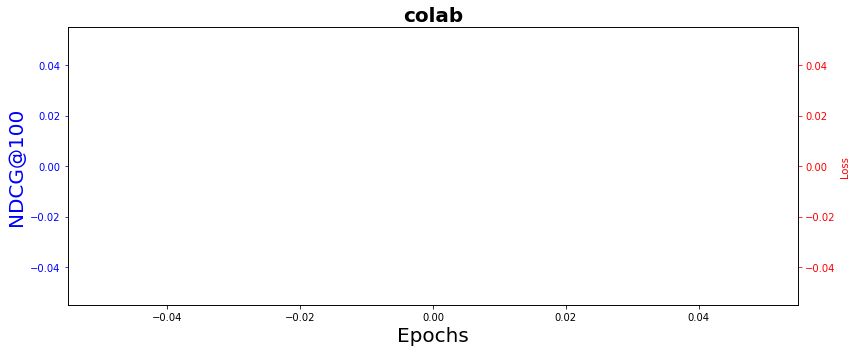

FileNotFoundError: ignored

In [13]:
def train(reader):
    model.train()
    total_loss = 0
    start_time = time.time()
    batch = 0
    batch_limit = int(train_reader.num_b)
    total_anneal_steps = 200000
    anneal = 0.0
    update_count = 0.0
    anneal_cap = 0.2

    for x, y_s in reader.iter():
        batch += 1
        
        # Empty the gradients
        model.zero_grad()
        optimizer.zero_grad()
    
        # Forward pass
        decoder_output, z_mean, z_log_sigma = model(x)
        
        # Backward pass
        loss = criterion(decoder_output, z_mean, z_log_sigma, y_s, anneal)
        loss.backward()
        optimizer.step()

        total_loss += loss.data
        
        # Anneal logic
        if total_anneal_steps > 0:
            anneal = min(anneal_cap, 1. * update_count / total_anneal_steps)
        else:
            anneal = anneal_cap
        update_count += 1.0
        
        # Logging mechanism
        if (batch % hyper_params['batch_log_interval'] == 0 and batch > 0) or batch == batch_limit:
            div = hyper_params['batch_log_interval']
            if batch == batch_limit: div = (batch_limit % hyper_params['batch_log_interval']) - 1
            if div <= 0: div = 1

            cur_loss = (total_loss.item() / div)
            elapsed = time.time() - start_time
            
            ss = '| epoch {:3d} | {:5d}/{:5d} batches | ms/batch {:5.2f} | loss {:5.4f}'.format(
                    epoch, batch, batch_limit, (elapsed * 1000) / div, cur_loss
            )
            
            file_write(hyper_params['log_file'], ss)

            total_loss = 0
            start_time = time.time()

# Train It..
train_reader, val_reader, test_reader, total_items = load_data(hyper_params)
hyper_params['total_items'] = total_items
hyper_params['testing_batch_limit'] = test_reader.num_b

file_write(hyper_params['log_file'], "\n\nSimulation run on: " + str(dt.datetime.now()) + "\n\n")
file_write(hyper_params['log_file'], "Data reading complete!")
file_write(hyper_params['log_file'], "Number of train batches: {:4d}".format(train_reader.num_b))
file_write(hyper_params['log_file'], "Number of validation batches: {:4d}".format(val_reader.num_b))
file_write(hyper_params['log_file'], "Number of test batches: {:4d}".format(test_reader.num_b))
file_write(hyper_params['log_file'], "Total Items: " + str(total_items) + "\n")

model = Model(hyper_params)
if is_cuda_available: 
    print(('SENDING MODEL TO CUDA...'))
    model.cuda()

criterion = VAELoss(hyper_params)

if hyper_params['optimizer'] == 'adagrad':
    optimizer = torch.optim.Adagrad(
        model.parameters(), weight_decay=hyper_params['weight_decay'], lr = hyper_params['learning_rate']
    )
elif hyper_params['optimizer'] == 'adadelta':
    optimizer = torch.optim.Adadelta(
        model.parameters(), weight_decay=hyper_params['weight_decay']
    )
elif hyper_params['optimizer'] == 'adam':
    optimizer = torch.optim.Adam(
        model.parameters(), weight_decay=hyper_params['weight_decay']
    )
elif hyper_params['optimizer'] == 'rmsprop':
    optimizer = torch.optim.RMSprop(
        model.parameters(), weight_decay=hyper_params['weight_decay']
    )
elif hyper_params['optimizer'] == 'radam':
    optimizer = geoopt.optim.RiemannianAdam(
        model.parameters(), weight_decay=hyper_params['weight_decay']
    )

file_write(hyper_params['log_file'], str(model))
file_write(hyper_params['log_file'], "\nModel Built!\nStarting Training...\n")

best_val_ndcg = None

try:
    for epoch in range(1, hyper_params['epochs'] + 1):
        epoch_start_time = time.time()
        
        train(train_reader)
        
        # Calulating the metrics on the train set
        metrics, _ = evaluate(model, criterion, train_reader, hyper_params, True)
        string = ""
        for m in metrics: string += " | " + m + ' = ' + str(metrics[m])
        string += ' (TRAIN)'
    
        # Calulating the metrics on the validation set
        metrics, _ = evaluate(model, criterion, val_reader, hyper_params, False)
        string2 = ""
        for m in metrics: string2 += " | " + m + ' = ' + str(metrics[m])
        string2 += ' (VAL)'

        ss  = '-' * 89
        ss += '\n| end of epoch {:3d} | time: {:5.2f}s'.format(epoch, (time.time() - epoch_start_time))
        ss += string
        ss += '\n'
        ss += '-' * 89
        ss += '\n| end of epoch {:3d} | time: {:5.2f}s'.format(epoch, (time.time() - epoch_start_time))
        ss += string2
        ss += '\n'
        ss += '-' * 89
        file_write(hyper_params['log_file'], ss)
        
        if not best_val_ndcg or metrics['NDCG@100'] >= best_val_ndcg:
            with open(hyper_params['model_file_name'], 'wb') as f:
                torch.save(model, f)
            best_val_ndcg = metrics['NDCG@100']

except KeyboardInterrupt: print('Exiting from training early')

# Plot Traning graph
f = open(model.hyper_params['log_file'])
lines = f.readlines()
lines.reverse()

train = []
test = []

for line in lines:
    if line[:10] == 'Simulation' and len(train) > 1:
        break
    elif line[:10] == 'Simulation' and len(train) <= 1:
        train, test = [], []
        
    if line[2:5] == 'end' and line[-5:-2] == 'VAL':
        test.append(line.strip().split("|"))
    elif line[2:5] == 'end' and line[-7:-2] == 'TRAIN':
        train.append(line.strip().split("|"))

train.reverse()
test.reverse()

train_ndcg = []
test_ndcg = []
test_loss, train_loss = [], []

for i in train:
    for metric in i:
        if metric.split("=")[0] == " NDCG@100 ":
            train_ndcg.append(float(metric.split('=')[1].split(' ')[1]))
        if metric.split("=")[0] == " loss ":
            train_loss.append(float(metric.split("=")[1].split(' ')[1]))

total, avg_runtime = 0.0, 0.0
for i in test:
    avg_runtime += float(i[2].split(" ")[2][:-1])
    total += 1.0
    
    for metric in i:
        if metric.split("=")[0] == " NDCG@100 ":
            test_ndcg.append(float(metric.split('=')[1].split(' ')[1]))
        if metric.split("=")[0] == " loss ":
            test_loss.append(float(metric.split("=")[1].split(' ')[1]))

fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.set_title(hyper_params["project_name"],fontweight="bold", size=20)
ax1.plot(test_ndcg, 'b-')
ax1.set_xlabel('Epochs', fontsize = 20.0)
ax1.set_ylabel('NDCG@100', color='b', fontsize = 20.0)
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(test_loss, 'r--')
ax2.set_ylabel('Loss', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
if not os.path.isdir("saved_plots/"):
    os.mkdir("saved_plots/")
fig.savefig("saved_plots/learning_curve_" + hyper_params["project_name"] + ".pdf")
plt.show()

# Checking metrics for the test set on best saved model
with open(hyper_params['model_file_name'], 'rb') as f:
    model = torch.load(f)
metrics, len_to_ndcg_at_100_map = evaluate(model, criterion, test_reader, hyper_params, False)

# Plot sequence length vs NDCG@100 graph
plot_len_vs_ndcg(len_to_ndcg_at_100_map)

string = ""
for m in metrics:
    string += " | " + m + ' = ' + str(metrics[m])

ss  = '=' * 89
ss += '\n| End of training'
ss += string + " (TEST)"
ss += '\n'
ss += '=' * 89
file_write(hyper_params['log_file'], ss)
print("average runtime per epoch =", round(avg_runtime / float(total), 4), "s")